In [ ]:
# Music Generation with RNNs

In [ ]:
# In this Notebook, we will explore building a Recurrent Neural Network (RNN) for music generation

In [ ]:
# 2.1 Dependencies

In [ ]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
COMET_API_KEY = "YOUR_COMET_API_KEY"

# Import Tensorflow 2.0
import tensorflow as tf

# Download and import the MIT Introduction to Deep Learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write
!apt-get install abcmidi timidity > /dev/null 2>&1


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# 2.2 Dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# download the dataset
songs = mdl.lab1.load_training_data()

# printing the example song
example_song = songs[0]
print("This is an Example Song from the above songs dataset")
print(example_song)

Found 817 songs in text
This is an Example Song from the above songs dataset
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [ ]:
# convert the ABC notation of the song to the audio file
mdl.lab1.play_song(example_song)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [ ]:
# 2.3 Process the dataset for the learning task

In [ ]:
# Vectorize the text
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
len(songs_joined)

200679

In [ ]:
### Vectorize the songs string ###
def vectorize_string(string):
  final_vector = []
  for i in range(len(string)):
    index_i = char2idx[string[i]]
    final_vector.append(index_i)
  return np.array(final_vector)

vectorized_songs = vectorize_string(songs_joined)

In [ ]:
len(vectorized_songs)

200679

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [ ]:
# Create training examples and targets

In [ ]:
### Batch definition to create training examples ###
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 31 ('F')
  expected output: 82 ('|')
Step   1
  input: 82 ('|')
  expected output: 32 ('G')
Step   2
  input: 32 ('G')
  expected output: 14 ('2')
Step   3
  input: 14 ('2')
  expected output: 1 (' ')
Step   4
  input: 1 (' ')
  expected output: 32 ('G')


In [ ]:
# 2.4 The Recurrent Neural Network (RNN) model
# tf.keras.layers.Embedding: This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with embedding_dim dimensions.
# tf.keras.layers.LSTM: Our LSTM network, with size units=rnn_units.
# tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [ ]:
# Define the RNN model
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [ ]:
### Defining the RNN Model ###

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units.
    LSTM(rnn_units),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size.
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

# Build a simple model with default hyperparameters. You will get the
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [ ]:
# Test out the RNN model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5353299 (20.42 MB)
Trainable params: 5353299 (20.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [ ]:
# Predictions from the untrained model

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([14, 63, 68, 56, 64, 30,  4, 18, 52, 58, 17, 70, 40, 46, 25, 78, 11,
        0, 60, 42, 67, 59, 61, 10, 31, 63, 24, 79, 59,  4, 29, 45, 77, 57,
       65, 79, 40, 27, 51, 33, 38, 62, 31, 64,  7, 39,  1, 43, 66, 12, 63,
       32, 49, 57, 50, 43, 21, 64, 45, 81, 28,  8, 52, 11, 67, 72, 61, 22,
       56, 31, 82, 51, 64,  5, 51, 65, 35, 15, 76, 11,  7, 50, 38, 61, 59,
       29, 12, 18, 45, 78, 57, 18,  8, 70, 11, 60,  5,  5, 55, 78])

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 "25\nT:McDonagh's\nZ: id:dc-reel-206\nM:C\nL:1/8\nK:E Dorian\nA|B2Ad BEED|E2BE E2BE|BAFA D3E|FDAD FDFA|!\nB2"

Next Char Predictions: 
 "2hmaiE#6[c5oOU>w/\neQldf.Fh=xd#DTvbjxOBZHMgFi)N Rk0hGXbYR9iTzC,[/lqf:aF|Zi'ZjJ3u/)YMfdD06Twb6,o/e''_w"


In [ ]:
# 2.5 Training the model: loss and training operations

In [ ]:
### Defining the loss function ###

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  return loss

example_batch_loss = compute_loss(y, pred) # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.420152


In [ ]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 5000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-4,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 2048,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [ ]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

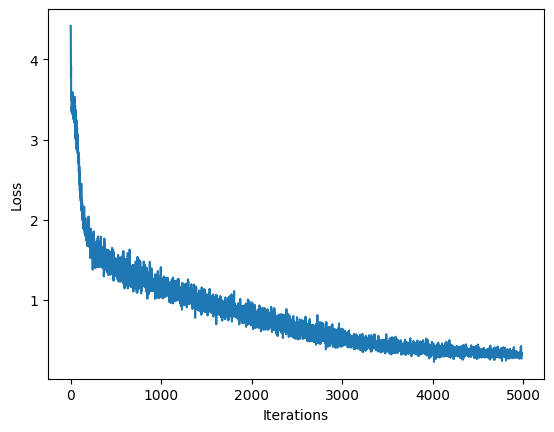

100%|██████████| 5000/5000 [09:42<00:00,  8.58it/s]
COMET INFO: Uploading 31 metrics, params and output messages


True

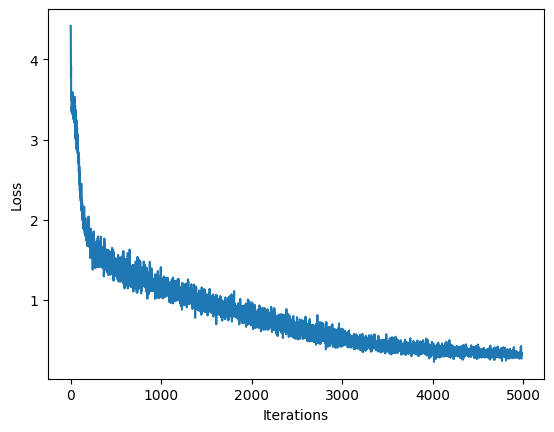

In [ ]:
### Define optimizer and training operation ###

model = build_model(vocab_size, embedding_dim=256, rnn_units=2048, batch_size=8)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    y_hat = model(x)

    loss = compute_loss(y, y_hat)

  # Now, compute the gradients
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)

  # log the loss to the Comet interface! we will be able to track it there.
  experiment.log_metric("loss", loss.numpy().mean(), step=iter)
  # Update the progress bar and also visualize within notebook
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
experiment.flush()

In [ ]:
model = build_model(vocab_size,embedding_dim=256, rnn_units=2048, batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (1, None, 256)            21248     
                                                                 
 lstm_10 (LSTM)              (1, None, 2048)           18882560  
                                                                 
 dense_10 (Dense)            (1, None, 83)             170067    
                                                                 
Total params: 19073875 (72.76 MB)
Trainable params: 19073875 (72.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  input_eval = [char2idx[start_string]]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)

      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))


In [ ]:
generated_text = generate_text(model, start_string="X", generation_length=1000)

100%|██████████| 1000/1000 [00:08<00:00, 120.04it/s]


In [ ]:
generated_text

'X:36\nT:Whand Trin\nZ: id:dc-jig-93\nM:6/8\nL:1/8\nK:A Mixolydian\ne3 ecA|ecA Bcd|e3 ecA|Bcd cBA|!\nA3 AFF|AF cFAd|g3|dcde fdec|dedc AGFG|!\nAB=cA dd2^c|defg agfd|cAFA G2:|!\nBc|dgg2 agfd|gage dega|bage dBGB|BAGE A2:|!\n\nX:39\nT:Chrisked cho Hufdfore\nZ: id:dc-polka-47\nM:2/4\nL:1/8\nK:A Major\nc2e e2B cBA|F2B B2c dcB|c2e e2a a2b|a26 e2|d4 f2|!\nB4 e2|A4 e2|A4 fe|d2 e4 f2|!\ng4 f2|e2 f2 g2|d4 c2|B2 A2 G2|c4 A2|B2 c2 d2|F2 G2 A2|B2 cd e2|e4 dc|d6|d4:|!\nde|fe ae|f2 ed|B2 Bc|BA B2:|!\nc2 c>B|AF F2|Ee ec|BA B3/2:|!\nK:D Major\nB|ABd edB|def gfg|fed edB|AFD DED|AFD D2:|!\nA|B2e fed|edB AFA|BEE GEE|B,EE G2A|BGE EBc|!\ndcA fef|gec dBA|a2a a2g|e2f g2:|!\nM:C\nL:1/8\nK:E Dorian\nEFGA BAFA|]!\ndedB G|Bdef dBAG|EGGFD D2:|!\nfg|agfa gfeg|fedf edBc|dBAF DEFB|ABde fdde|!\nfaaf afdf|gfed dcBA|f2af bgfe|defd edBd|]!\n\nX:110\nT:Flag of Tunser\nZ: id:dc-reel-246\nM:C\nL:1/8\nK:E Major\nB2c|d3c dfed|cABc AFEF|!\nA2cA eAfA|eAfA ecBc|f2e2 d2:|!\ncd|e2fe dcdB|AFA2 fdAd|f2e2 e2de|fgfe dfd^c d2:|!\nDD|GBd

In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
mdl.lab1.play_song(generated_text)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# when done, end the comet experiment
experiment.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : grand_cattle_4786
COMET INFO:     url                   : https://www.comet.com/akshaybitlingu/6s191-lab1-part2/2629fdeecd1946c9ab63c4f8a411e092
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [5000] : (0.2257651835680008, 4.418118476867676)
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 8
COMET INFO:     embedding_dim           : 256
COMET INFO:     learning_rate           : 0.0005
COMET INFO:     num_training_iterations : 5000
COMET INFO:     rnn_units               : 2048
COMET INFO:     seq_length              : 100
COMET INFO:   Uploads:
COMET INFO